In [9]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

plt.style.use("seaborn-talk")
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('inputs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

inputs\AgeGroupDetails.csv
inputs\covid_19_india.csv
inputs\HospitalBedsIndia.csv
inputs\ICMRTestingDetails.csv
inputs\ICMRTestingLabs.csv
inputs\IndividualDetails.csv
inputs\population_india_census2011.csv
inputs\StatewiseTestingDetails.csv


In [166]:
covid_india = pd.read_csv('inputs\covid_19_india.csv')
individual_details = pd.read_csv('inputs\IndividualDetails.csv')

## EDA - Individual Details

In [60]:
individual_details.head()

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,current_status,status_change_date,notes
0,0,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
1,1,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
2,2,KL-KS-P1,03/02/2020,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
3,3,DL-P1,02/03/2020,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15/03/2020,"Travelled from Austria, Italy"
4,4,TS-P1,02/03/2020,24,M,Hyderabad,Hyderabad,Telangana,India,Recovered,02/03/2020,"Travelled from Dubai to Bangalore on 20th Feb,..."


The age of patients in rows 924 to 927 is labelled as '28-35'. We will replace it with the average value = 31.
Then, we cast it to float.

In [308]:
individual_details['age'] = individual_details['age'].apply(lambda row: 33 if row == "28-35" else row)
individual_details['age'] = individual_details['age'].astype(float)

In [310]:
def getAgeBins(row):
    if np.isnan(row):
        return "NaN"
    elif row > 0 and row <= 9:
        return "0-9"
    elif row > 9 and row <= 19:
        return "10-19"
    elif row > 19 and row <= 29:
        return "20-29"
    elif row > 29 and row <= 39:
        return "30-39"
    elif row > 39 and row <= 49:
        return "40-49"
    elif row > 49 and row <= 59:
        return "50-59"
    elif row > 59 and row <= 69:
        return "60-69"
    elif row > 69 and row <= 79:
        return "70-79"
    elif row > 79 and row <= 89:
        return "80-89"
    else:
        return ">90"
    
individual_details['age_bins'] = individual_details['age'].apply(lambda age: getAgeBins(age))
individual_details['age_bins'].head()

0    20-29
1      NaN
2      NaN
3    40-49
4    20-29
Name: age_bins, dtype: object

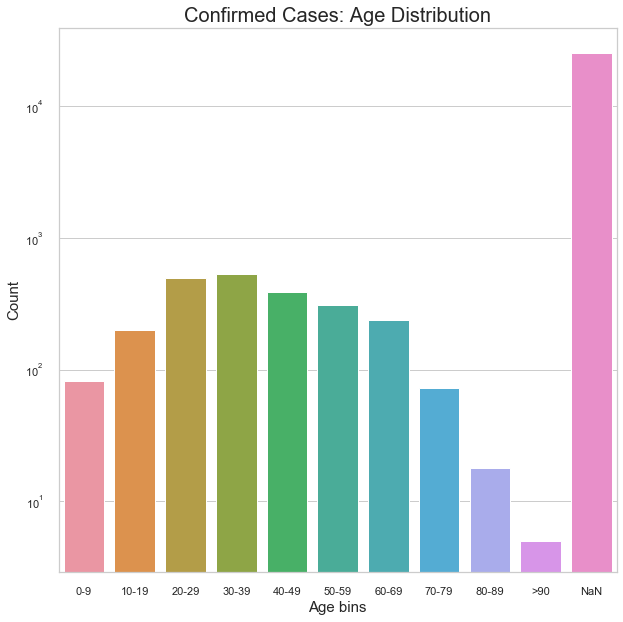

In [328]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.set_yscale('log')
sns.countplot(x=individual_details['age_bins'], order=individual_details['age_bins'].value_counts().index.sort_values())
plt.title('Confirmed Cases: Age Distribution', fontsize=20)
plt.xlabel('Age bins', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

In [335]:
individual_details['gender'] = individual_details['gender'].fillna('Missing')
individual_details['gender'].value_counts()

Missing    22577
M           3547
F           1766
Name: gender, dtype: int64

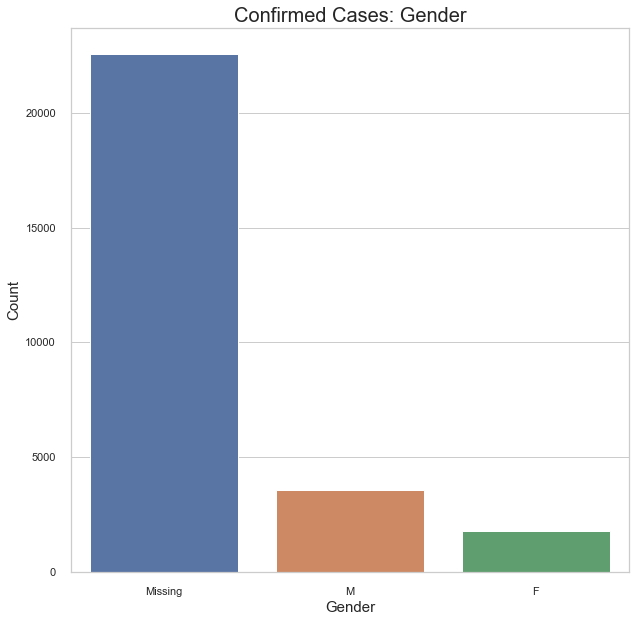

In [340]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.countplot(x=individual_details['gender'], order=individual_details['gender'].value_counts().index)
plt.title('Confirmed Cases: Gender', fontsize=20)
plt.xlabel('Gender', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

## EDA - COVID Counts

In [70]:
covid_india.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


In [71]:
covid_india.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       1671 non-null   int64 
 1   Date                      1671 non-null   object
 2   Time                      1671 non-null   object
 3   State/UnionTerritory      1671 non-null   object
 4   ConfirmedIndianNational   1671 non-null   object
 5   ConfirmedForeignNational  1671 non-null   object
 6   Cured                     1671 non-null   int64 
 7   Deaths                    1671 non-null   int64 
 8   Confirmed                 1671 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 117.6+ KB


In [72]:
covid_india.describe()

,Sno,Cured,Deaths,Confirmed
count,1671.000000,1671.000000,1671.000000,1671.000000
mean,836.000000,86.929982,13.054458,408.981448
std,482.520466,251.026352,49.430082,1188.132537
min,1.000000,0.000000,0.000000,0.000000
25%,418.500000,0.000000,0.000000,5.000000
50%,836.000000,5.000000,0.000000,32.000000
75%,1253.500000,34.000000,4.000000,258.500000
max,1671.000000,2819.000000,617.000000,15525.000000


We will drop the columns - Sno, Time, ConfirmedIndianNational, ConfirmedForeignNational.

In [167]:
covid_india = covid_india.drop(['Sno', 'Time', 'ConfirmedIndianNational', 'ConfirmedForeignNational'], axis = 1)
covid_india['Date'] = pd.to_datetime(covid_india['Date'],dayfirst=True)
covid_india.head()

,Date,State/UnionTerritory,Cured,Deaths,Confirmed
0,2020-01-30,Kerala,0,0,1
1,2020-01-31,Kerala,0,0,1
2,2020-02-01,Kerala,0,0,2
3,2020-02-02,Kerala,0,0,3
4,2020-02-03,Kerala,0,0,3


Adding an 'Active' column.

In [168]:
covid_india['Active'] = covid_india['Confirmed'] - covid_india['Cured'] - covid_india['Deaths']
covid_india.head()

,Date,State/UnionTerritory,Cured,Deaths,Confirmed,Active
0,2020-01-30,Kerala,0,0,1,1
1,2020-01-31,Kerala,0,0,1,1
2,2020-02-01,Kerala,0,0,2,2
3,2020-02-02,Kerala,0,0,3,3
4,2020-02-03,Kerala,0,0,3,3


Since each new row gives the total confirmed cases in that state, we will keep only the maximum value.

In [169]:
state_cases = covid_india.groupby('State/UnionTerritory').max().reset_index()
state_cases = state_cases.drop(['Date'], axis=1)
state_cases = state_cases.sort_values('Confirmed', ascending = False)
state_cases.head(10)

,State/UnionTerritory,Cured,Deaths,Confirmed,Active
20,Maharashtra,2819,617,15525,12089
10,Gujarat,1381,368,6245,4496
8,Delhi,1468,64,5104,3572
30,Tamil Nadu,1485,33,4058,2540
29,Rajasthan,1525,89,3158,1777
19,Madhya Pradesh,1000,176,3049,2100
34,Uttar Pradesh,987,56,2880,1939
1,Andhra Pradesh,589,36,1717,1092
28,Punjab,133,25,1451,1293
36,West Bengal,364,140,1344,908


In [109]:
total_cases = state_cases['Confirmed'].sum()
print('India has a total of {} confirmed cases as of May 6th.'.format(total_cases))

India has a total of 49514 confirmed cases as of May 6th.


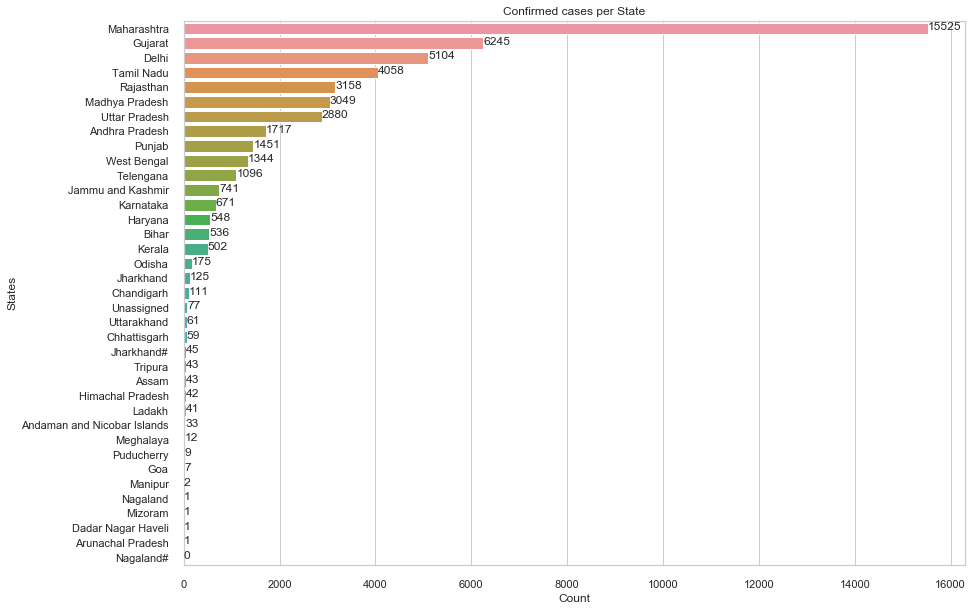

In [359]:
plt.figure(figsize=(14,10))
#ax = sns.barplot(y = states, x = confirmed)
ax = sns.barplot(data = state_cases, x = confirmed, y = states)
plt.title('Confirmed cases per State')
plt.xlabel('Count')
plt.ylabel('States')

initialx=0
for p in ax.patches:
    ax.text(p.get_width(),initialx+p.get_height()/8,'{:1.0f}'.format(p.get_width()))
    initialx+=1

plt.show()

Plot of the number of Confirmed cases in India.

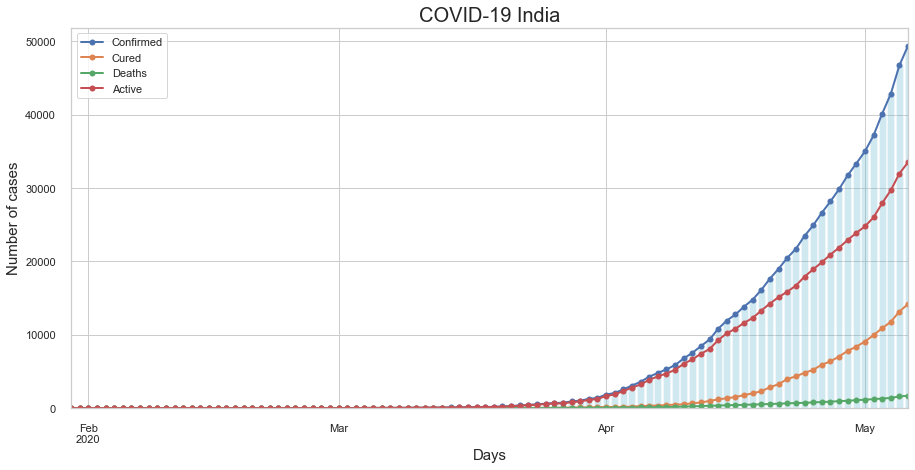

In [175]:
cases = covid_india.groupby('Date').sum()[['Confirmed', 'Cured', 'Deaths', 'Active']]
sns.set(style = 'whitegrid')
cases.plot(kind='line', figsize = (15,7) , marker='o',linewidth=2)
plt.bar(cases.index, cases['Confirmed'],alpha=0.3,color='c')
plt.xlabel('Days', fontsize=15)
plt.ylabel('Number of cases', fontsize=15)
plt.title('COVID-19 India',fontsize=20)
plt.legend()
plt.show()